In [8]:
using Random, Distributions, Plots

### ISIの累積により発火時刻を求める手法¶

In [27]:
Random.seed!(0)

T = 1000
dt = 1f0
nt = Int32(T/dt)

n_neurons = 10
fr = 30

# ISIの確率密度関数に従った乱数(つまり発火率)を返す(これがスパイク時刻になる)
isi = 1/(fr*dt*1e-3) * randexp(Int(nt*1.5/fr), n_neurons)
# それぞれの神経に対して発火した時刻を累積する
spike_time = cumsum(isi, dims=1); # ISIを累積

In [28]:
cumsum(isi, dims=1)

50×10 Array{Float64,2}:
   26.0798    11.7774    19.2929  …    15.7382    46.6112   162.958
   60.7539    30.4794    26.9378      104.168    167.988    171.206
   71.763     95.3457    65.0419      201.379    184.834    184.906
   76.6791   153.2       83.5601      235.58     258.265    202.674
   94.1527   178.9       88.6296      244.253    351.652    204.407
  121.853    229.522     91.9738  …   286.841    372.014    207.078
  134.116    250.21      98.6145      299.138    384.879    212.515
  135.094    275.585    178.593       304.36     413.277    213.249
  178.137    322.945    216.448       328.301    460.383    217.375
  194.24     357.412    304.814       340.815    521.438    218.561
  232.864    358.367    364.628   …   398.443    536.567    227.46
  295.653    418.464    379.827       421.181    588.021    277.066
  355.817    435.453    399.039       479.48     616.376    296.112
    ⋮                             ⋱                        
 1196.04    1486.42    1334.8    

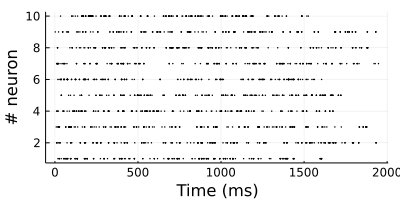

In [29]:
for i=1:n_neurons
    plot!(spike_time[:,i], i*ones(Int(nt*1.5/fr)) ,st=:scatter,markersize=1,color="black")
end
plot(p1, 
    xlabel = "Time (ms)", 
    ylabel = "# neuron",legend=false, size=(400,200))

In [34]:
spike_time[spike_time .> nt - 1] .= 1 # ntを超える場合を1に
spike_time = round.(Int, spike_time) # float to int
spikes = zeros(nt, n_neurons) # スパイク記録変数

for i=1:n_neurons    
    spikes[spike_time[:, i], i] .= 1
end

# 最初のntを超える場合を1にした時の対策
spikes[1] = 0 # (spike_time=1)の発火を削除
println("Num. of spikes : ", sum(spikes))
println("Firing rate : ", sum(spikes)/(n_neurons*T)*1e3, "Hz")

Num. of spikes : 293.0
Firing rate : 29.3Hz


### Δ𝑡 間の発火確率が 𝜆Δ𝑡 であることを利用する方法

In [30]:
Random.seed!(0) # set random seed

T = 1000 # ms
dt = 1f0 # ms
nt = Int(T/dt) # number of timesteps

n_neurons = 10 # ニューロンの数
fr = 30 # ポアソンスパイクの発火率(Hz)

spikes = rand(nt, n_neurons) .< fr*dt*1e-3

println("Num. of spikes : ", sum(spikes))
println("Firing rate : ", sum(spikes)/(n_neurons*T)*1e3, "Hz")

Num. of spikes : 304
Firing rate : 30.4Hz


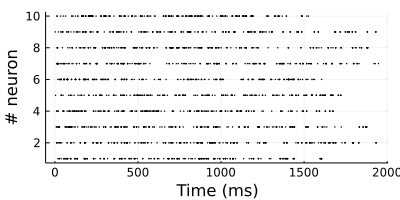

In [37]:
function rasterplot(spikes)
    # input spike -> time, #neurons
    spike_inds = Tuple.(findall(x -> x > 0, spikes)) # 行列内で0を超えてるスパイクのインデックスの要素を取得
    spike_time = first.(spike_inds) # スパイク時系列
    neuron_inds = last.(spike_inds) # 神経の番号(1~n_neurons)
    
    # raster plot
    plot(spike_time, neuron_inds ,st=:scatter,markersize=1,color="black")
    plot(p1, 
    xlabel = "Time (ms)", 
    ylabel = "# neuron",legend=false, size=(400,200))
end
rasterplot(spikes)

### 非定常ポワソン過程

In [39]:
Random.seed!(0)

T = 1000
dt = 1f0
nt = Int32(T/dt)

n_neurons = Int32(10)

t = Array{Float32}(1:nt)*dt
fr = 30(sin.(1e-2t)).^2 # ポアソンスパイクの発火率(Hz)

spikes = rand(nt, n_neurons) .< fr*dt*1e-3 # 1e-3をかけるのはmsで評価しているため

println("Num. of spikes : ", sum(spikes))
println("Firing rate : ", sum(spikes)/(n_neurons*T)*1e3, "Hz")

Num. of spikes : 148
Firing rate : 14.8Hz


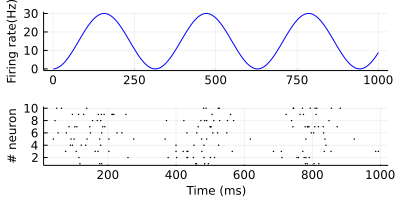

In [47]:
function rasterplot(spikes)
    # input spike -> time, #neurons
    spike_inds = Tuple.(findall(x -> x > 0, spikes)) # 行列内で0を超えてるスパイクのインデックスの要素を取得
    spike_time = first.(spike_inds) # スパイク時系列
    neuron_inds = last.(spike_inds) # 神経の番号(1~n_neurons)
    
    # raster plot
    p1 = plot(t, fr, color="blue")
    p2 = plot(spike_time, neuron_inds ,st=:scatter,markersize=1,color="black")
    plot(p1, p2 , guidefont=font(8),
    xlabel = ["" "Time (ms)"], 
    ylabel = ["Firing rate(Hz)" "# neuron"],legend=false, size=(400,200), layout = grid(2, 1,  heights=[0.5,0.5]))
end
rasterplot(spikes)

### 死時間付きポアソン過程モデル (Poisson process with dead time, PPD)

In [54]:
function rasterplot(spikes)
    # input spike -> time, #neurons
    spike_inds = Tuple.(findall(x -> x > 0, spikes)) # 行列内で0を超えてるスパイクのインデックスの要素を取得
    spike_time = first.(spike_inds) # スパイク時系列
    neuron_inds = last.(spike_inds) # 神経の番号(1~n_neurons)
    
    # raster plot
    plot(spike_time, neuron_inds ,st=:scatter,markersize=1,color="black")
    plot(p1, 
    xlabel = "Time (ms)", 
    ylabel = "# neuron",legend=false, size=(400,200))
end

rasterplot (generic function with 1 method)

  0.006665 seconds (26.96 k allocations: 1.342 MiB)
Num. of spikes : 267.0
Firing rate : 26.700000000000003Hz


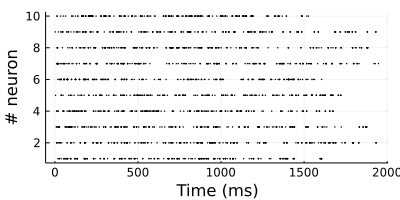

In [55]:
Random.seed!(0)

T = 1000
dt = 1f0
nt = Int32(T/dt)
tref = 5f0 # 不応期(ms)

n_neurons = Int32(10)
fr = 30

tlast, spikes = zeros(n_neurons), zeros(nt, n_neurons)

# simulation
@time for i=1:nt
    fire = rand(n_neurons) .< fr*dt*1e-3
    spikes[i, :] = ((dt*i) .> (tlast .+ tref)) .* fire # 不応期の対処
    tlast[:] = tlast .* (1 .- fire) + dt*i * fire # fireなら発火時刻を更新する
end

println("Num. of spikes : ", sum(spikes))
println("Firing rate : ", sum(spikes)/(n_neurons*T)*1e3, "Hz")

rasterplot(spikes)